# Hearts AI Training Visualization
This notebook visualizes the training progress by reading the logs generated by `train.py`.

**Metrics Tracked:**
1. **Score per Episode**: The raw score obtained by the AI (Lower is better).
2. **Average Score**: Moving average of the score (to see trends).
3. **Loss**: The training loss (Policy Gradient loss).

**Instructions:**
1. Run `python train.py` in your terminal.
2. Run the cells below to start the live dashboard.


In [4]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import time
import os
import json
import datetime

# Configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
LOG_FILE = "training_log.json"
RES_DIR = "res"

if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [5]:
def moving_average(data, window_size=50):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def save_snapshot(episodes, scores, avg_scores, p_losses, v_losses, difficulty=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot Scores
    if scores:
        ax1.plot(episodes, scores, alpha=0.3, color='blue', label='Raw Score')
        ax1.plot(episodes, avg_scores, color='red', linewidth=2, label='Avg Score')
        ax1.set_title('Training Score')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Score')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Plot Policy Loss
    if p_losses:
        if len(p_losses) > 50:
            smoothed = moving_average(p_losses, 50)
            x_axis = episodes[len(episodes)-len(smoothed):]
            ax2.plot(x_axis, smoothed, color='purple', label='Policy Loss (MA 50)')
        else:
            ax2.plot(episodes, p_losses, color='purple', label='Policy Loss')
            
        ax2.set_title('Policy Loss')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # Plot Value Loss
    if v_losses:
        if len(v_losses) > 50:
            smoothed = moving_average(v_losses, 50)
            x_axis = episodes[len(episodes)-len(smoothed):]
            ax3.plot(x_axis, smoothed, color='green', label='Value Loss (MA 50)')
        else:
            ax3.plot(episodes, v_losses, color='green', label='Value Loss')
            
        ax3.set_title('Value Loss')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Loss')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    last_ep = episodes[-1] if episodes else 0
    filename = f"{RES_DIR}/train_{timestamp}_ep{last_ep}.png"
    plt.savefig(filename)
    plt.close(fig)
    print(f"Snapshot saved to {filename}")

def live_dashboard(save_interval=50):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    print("Waiting for log file...")
    while not os.path.exists(LOG_FILE):
        time.sleep(1)
        
    print("Log file found. Starting visualization...")
    
    last_update = 0
    last_save = 0
    
    try:
        while True:
            # Read log file
            try:
                with open(LOG_FILE, 'r') as f:
                    content = f.read()
                    if not content:
                        continue
                    data = json.loads(content)
            except json.JSONDecodeError:
                time.sleep(0.1)
                continue
                
            episodes = data.get('episodes', [])
            scores = data.get('scores', [])
            avg_scores = data.get('avg_scores', [])
            p_losses = data.get('policy_losses', [])
            v_losses = data.get('value_losses', [])
            difficulty = data.get('difficulty', [])
            
            if len(episodes) == last_update:
                time.sleep(1)
                continue
                
            last_update = len(episodes)
            
            # Update Plots
            ax1.clear()
            ax2.clear()
            ax3.clear()
            
            # Plot Scores
            if scores:
                ax1.plot(episodes, scores, alpha=0.3, color='blue', label='Raw Score')
                ax1.plot(episodes, avg_scores, color='red', linewidth=2, label='Avg Score')
                ax1.set_title('Training Score')
                ax1.set_xlabel('Episode')
                ax1.set_ylabel('Score')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
            
            # Plot Policy Loss
            if p_losses:
                if len(p_losses) > 50:
                    smoothed = moving_average(p_losses, 50)
                    x_axis = episodes[len(episodes)-len(smoothed):]
                    ax2.plot(x_axis, smoothed, color='purple', label='Policy Loss (MA 50)')
                else:
                    ax2.plot(episodes, p_losses, color='purple', label='Policy Loss')
                    
                ax2.set_title('Policy Loss')
                ax2.set_xlabel('Episode')
                ax2.set_ylabel('Loss')
                ax2.legend()
                ax2.grid(True, alpha=0.3)

            # Plot Value Loss
            if v_losses:
                if len(v_losses) > 50:
                    smoothed = moving_average(v_losses, 50)
                    x_axis = episodes[len(episodes)-len(smoothed):]
                    ax3.plot(x_axis, smoothed, color='green', label='Value Loss (MA 50)')
                else:
                    ax3.plot(episodes, v_losses, color='green', label='Value Loss')
                    
                ax3.set_title('Value Loss')
                ax3.set_xlabel('Episode')
                ax3.set_ylabel('Loss')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
            
            display(fig)
            clear_output(wait=True)
            
            # Auto-save snapshot
            if episodes and episodes[-1] - last_save >= save_interval:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"{RES_DIR}/train_{timestamp}_ep{episodes[-1]}.png"
                fig.savefig(filename)
                last_save = episodes[-1]
                
    except KeyboardInterrupt:
        print("Visualization stopped.")

Visualization stopped.


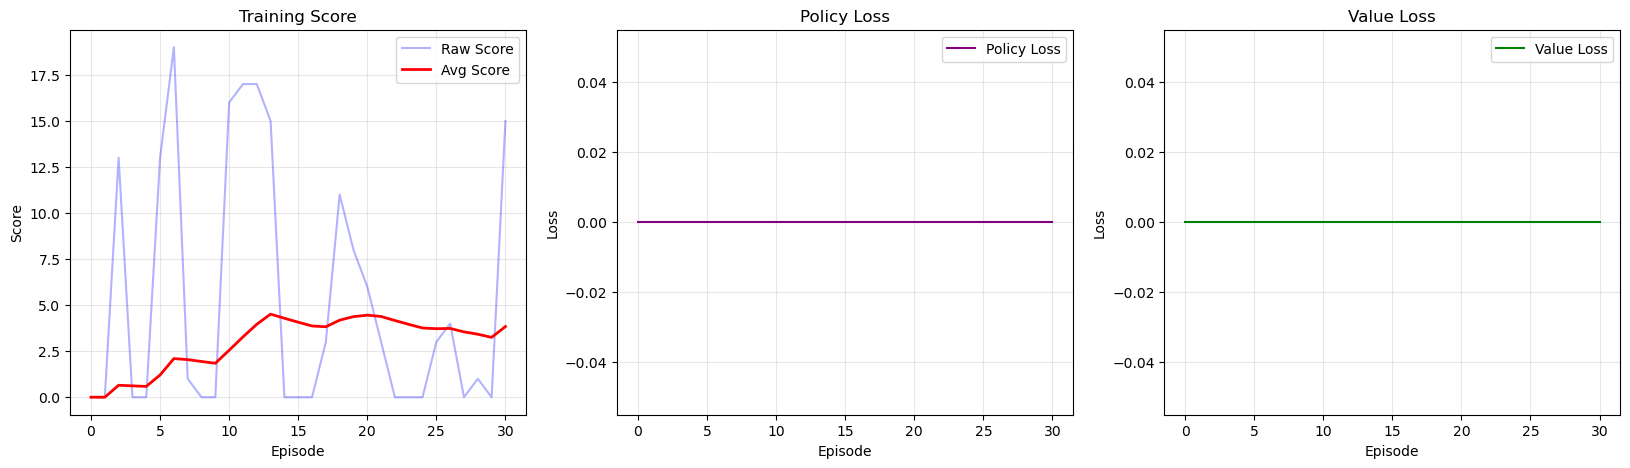

In [6]:
# Run this cell to start the dashboard
live_dashboard()